In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import pickle
import cv2
from PIL import Image
from tqdm import tqdm

In [3]:
import gdown
gdown.download("https://drive.google.com/uc?id=1bpHLZxFYMVC0qEqeseYXo1rMme-JbwR6",'data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1bpHLZxFYMVC0qEqeseYXo1rMme-JbwR6
From (redirected): https://drive.google.com/uc?id=1bpHLZxFYMVC0qEqeseYXo1rMme-JbwR6&confirm=t&uuid=0b94cc8b-03f0-4a08-8fda-0c93ca48e48c
To: /kaggle/working/data.zip
100%|██████████| 504M/504M [00:02<00:00, 248MB/s] 


'data.zip'

In [4]:
!unzip data.zip

Archive:  data.zip
   creating: content/data/
   creating: content/data/pickles/
  inflating: content/data/pickles/audio_emotion.pkl  
  inflating: content/data/pickles/data_sentiment.p  
  inflating: content/data/pickles/audio_sentiment.pkl  
  inflating: content/data/pickles/audio_embeddings_feature_selection_emotion.pkl  
  inflating: content/data/pickles/audio_embeddings_feature_selection_sentiment.pkl  
  inflating: content/data/pickles/data_emotion.p  
   creating: content/data/.ipynb_checkpoints/
  inflating: content/data_helpers.py  
  inflating: content/train_dataset.pt  
  inflating: content/val_dataset.pt  


In [5]:
import shutil
import os
path = '/kaggle/working/content'
contents_dir = "/kaggle/working/"

# Check if 'contents' directory exists, create it if it doesn't
if not os.path.exists(contents_dir):
    os.makedirs(contents_dir)

# Move the contents of the downloaded dataset to the 'contents' directory.
for item in os.listdir(path):
    source_path = os.path.join(path, item)
    destination_path = os.path.join(contents_dir, item)
    if os.path.isfile(source_path):
      shutil.move(source_path, destination_path)
    else:
      shutil.move(source_path, destination_path)


In [6]:
import importlib.util
spec = importlib.util.spec_from_file_location("data_helpers", "/kaggle/working/data_helpers.py")
data_helpers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(data_helpers)

In [7]:
dataloader = data_helpers.Dataloader
BATCH_SIZE = 4
NUM_EPOCHS = 30
LEARNING_RATE = 0.01

DATA_DIR = "/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/"
FRAME_SAVE_DIR = "./frames/"

In [8]:
emotion2idx = {'neutral': 0, 'anger': 1, 'disgust': 2, 'sadness': 3, 'joy': 4, 'surprise': 5, 'fear': 6}
sentiment2idx = {'neutral': 0, 'positive': 1, 'negative': 2}

In [9]:
def extract_frames(split_name, csv_path, video_dir, output_dir, frame_interval=3):
    print(f"\n[INFO] Extracting frames for {split_name}")
    df = pd.read_csv(csv_path)
    os.makedirs(output_dir, exist_ok=True)
    videos = os.listdir(video_dir)

    for _, row in tqdm(df.iterrows(), total=len(df)):
        dia_id = row['Dialogue_ID']
        utt_id = row['Utterance_ID']
        vid_name = f'dia{dia_id}_utt{utt_id}.mp4'

        if vid_name not in videos:
            continue

        cap = cv2.VideoCapture(os.path.join(video_dir, vid_name))
        fps = cap.get(cv2.CAP_PROP_FPS)
        interval = int(fps * frame_interval) if fps > 0 else 30
        save_dir = os.path.join(output_dir, f"{dia_id}_{utt_id}")
        os.makedirs(save_dir, exist_ok=True)

        frame_idx, save_idx = 0, 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if frame_idx % interval == 0:
                frame = cv2.resize(frame, (224, 224))
                cv2.imwrite(os.path.join(save_dir, f"frame_{save_idx:03d}.jpg"), frame)
                save_idx += 1
            frame_idx += 1
        cap.release()
    print(f"[INFO] Done extracting {split_name} frames")


In [10]:
def build_label_dict(csv_path):
    df = pd.read_csv(csv_path)
    labels = {}
    for _, row in df.iterrows():
        vid_key = f"{row['Dialogue_ID']}_{row['Utterance_ID']}.mp4"
        labels[vid_key] = {
            'emotion': emotion2idx[row['Emotion'].lower()],
            'sentiment': sentiment2idx[row['Sentiment'].lower()]
        }
    return labels


In [11]:
class AudioVideoDataset(Dataset):
    def __init__(self, audio_feats, frames_root, labels, transform=None):
        self.audio_feats = audio_feats
        self.frames_root = frames_root
        self.labels = labels
        self.keys = list(labels.keys())
        self.transform = transform

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        video_key = self.keys[idx].replace('.mp4', '')
        audio = torch.tensor(self.audio_feats[video_key], dtype=torch.float32)

        frame_path = os.path.join(self.frames_root, video_key, 'frame_000.jpg')
        image = Image.open(frame_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        sent_label = torch.tensor(self.labels[self.keys[idx]]['sentiment'], dtype=torch.long)
        emo_label = torch.tensor(self.labels[self.keys[idx]]['emotion'], dtype=torch.long)

        return audio, image, sent_label, emo_label


In [12]:
class AudioBranch(nn.Module):
    def __init__(self, input_dim=1422):
        super(AudioBranch, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, 448, batch_first=True, bidirectional=True, dropout=0.35)
        self.bn1 = nn.BatchNorm1d(448*2)

        self.lstm2 = nn.LSTM(448*2, 448, batch_first=True, bidirectional=True, dropout=0.35)
        self.bn2 = nn.BatchNorm1d(448*2)

        self.fc1 = nn.Linear(448*2, 384)
        self.dropout1 = nn.Dropout(0.4)
        self.bn3 = nn.BatchNorm1d(384)

        self.fc2 = nn.Linear(384, 192)
        self.dropout2 = nn.Dropout(0.4)

    def forward(self, x):
        out, _ = self.lstm1(x)
        # out = self.bn1(out)
        out, _ = self.lstm2(out)
        # out = self.bn2(out)
        # print(out.shape)
        out = torch.relu(self.fc1(out))
        out = self.dropout1(out)
        out = out.reshape((-1,384))
        # print(out.shape)
        # out = self.bn3(out)
        out = torch.relu(self.fc2(out))
        # out = self.dropout2(out)
        return out

class MELD_VGG16(nn.Module):
    def __init__(self, feature_dim=100):
        super(MELD_VGG16, self).__init__()
        vgg16 = models.vgg16_bn(pretrained=True)
        self.features = vgg16.features
        self.avgpool = vgg16.avgpool
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 7 * 7, feature_dim)
        self.relu_fc = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        features = self.relu_fc(self.fc1(x))
        return features

class AudioVideoFusion(nn.Module):
    def __init__(self, audio_input_dim=1422, video_feature_dim=100, fusion_dim=256):
        super(AudioVideoFusion, self).__init__()
        self.audio_branch = AudioBranch(audio_input_dim)
        self.video_branch = MELD_VGG16(feature_dim=video_feature_dim)

        self.fusion_fc = nn.Linear(192 + video_feature_dim, fusion_dim)
        self.relu = nn.ReLU()

        self.sentiment_head = nn.Linear(fusion_dim, 3)
        self.emotion_head = nn.Linear(fusion_dim, 7)

    def forward(self, audio_input, video_input):
        audio_feat = self.audio_branch(audio_input)
        video_feat = self.video_branch(video_input)
        combined = torch.cat((audio_feat, video_feat), dim=1)
        fusion = self.relu(self.fusion_fc(combined))
        sentiment_logits = self.sentiment_head(fusion)
        emotion_logits = self.emotion_head(fusion)
        return sentiment_logits, emotion_logits


In [17]:
def train_model(model, train_loader, val_loader, device, epochs=30):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # class_counts = [1256, 521, 833]
    
    # Inverse proportional weights
    # weights = torch.tensor([1.0/c for c in class_counts], dtype=torch.float32)
    # weights = weights / weights.sum()  # normalize
    # sent_criterion = nn.CrossEntropyLoss(weight=weights.to(device))
    sent_criterion = nn.CrossEntropyLoss()
    emo_criterion = nn.CrossEntropyLoss()
    model.to(device)

    best_loss = float('inf')
    trigger_times = 0
    patience = 5

    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for audio, video, sent_label, emo_label in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
            audio, video, sent_label, emo_label = audio.to(device), video.to(device), sent_label.to(device), emo_label.to(device)

            optimizer.zero_grad()
            sent_out, emo_out = model(audio, video)

            loss = sent_criterion(sent_out, sent_label) 
            # + emo_criterion(emo_out, emo_label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        val_loss, val_accuracy = evaluate_model(model, val_loader, device, sent_criterion, emo_criterion)
        print(f"Epoch {epoch+1}: Train Loss={train_loss/len(train_loader):.4f}, Val Loss={val_loss:.4f}")

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_fusion_model_sent.pth")
            print("[INFO] Best model saved!")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("[INFO] Early stopping")
                break
    return train_losses, val_losses, val_accuracies

def evaluate_model(model, loader, device, sent_criterion, emo_criterion):
    model.eval()
    total_loss = 0
    total_correct_sentiment = 0
    # total_correct_emotion = 0
    total_samples = 0

    with torch.no_grad():
        for audio, video, sent_label, emo_label in loader:
            audio, video, sent_label, emo_label = audio.to(device), video.to(device), sent_label.to(device), emo_label.to(device)
            sent_out, emo_out = model(audio, video)

            loss = sent_criterion(sent_out, sent_label)
            #+ emo_criterion(emo_out, emo_label)
            total_loss += loss.item()

            sent_preds = torch.argmax(sent_out, dim=1)
            # emo_preds = torch.argmax(emo_out, dim=1)

            total_correct_sentiment += (sent_preds == sent_label).sum().item()
            # total_correct_emotion += (emo_preds == emo_label).sum().item()
            total_samples += sent_label.size(0)

    avg_loss = total_loss / len(loader)
    sentiment_accuracy = total_correct_sentiment / total_samples
    # emotion_accuracy = total_correct_emotion / total_samples

    print(f"Evaluation Results - Loss: {avg_loss:.4f}")#, Sentiment Accuracy: {sentiment_accuracy:.4f}")#, Emotion Accuracy: {emotion_accuracy:.4f}")
    return avg_loss, sentiment_accuracy#, emotion_accuracy


In [14]:
# Step 1: Frame extraction
if not os.path.exists('train_dataset_sent.pt') or not os.path.exists(os.path.join(FRAME_SAVE_DIR, 'train')):
    if not os.path.exists(os.path.join(FRAME_SAVE_DIR, 'train')):
        extract_frames('train', os.path.join(DATA_DIR, 'train/train_sent_emo.csv'), os.path.join(DATA_DIR, 'train/train_splits'), os.path.join(FRAME_SAVE_DIR, 'train'))
        extract_frames('val', os.path.join(DATA_DIR, 'dev_sent_emo.csv'), os.path.join(DATA_DIR, 'dev/dev_splits_complete'), os.path.join(FRAME_SAVE_DIR, 'val'))
        extract_frames('test', os.path.join(DATA_DIR, 'test_sent_emo.csv'), os.path.join(DATA_DIR, 'test/output_repeated_splits_test'), os.path.join(FRAME_SAVE_DIR, 'test'))

    # Step 2: Label preparation
    train_labels = build_label_dict(os.path.join(DATA_DIR, 'train/train_sent_emo.csv'))
    val_labels = build_label_dict(os.path.join(DATA_DIR, 'dev_sent_emo.csv'))

    # Step 3: Load Audio Features from Dataloader
    audio_loader = dataloader(mode='Sentiment')
    audio_loader.load_audio_data()
    audio_feats_train = audio_loader.train_audio_emb
    audio_feats_val = audio_loader.val_audio_emb

    # Step 4: Datasets and Loaders
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = AudioVideoDataset(audio_feats_train, './frames/train', train_labels, transform)
    val_dataset = AudioVideoDataset(audio_feats_val, './frames/val', val_labels, transform)
    torch.save(train_dataset, 'train_dataset_sent.pt')
    torch.save(val_dataset, 'val_dataset_sent.pt')
else:
    train_dataset = torch.load('train_dataset_sent.pt',weights_only=False)
    val_dataset = torch.load('val_dataset_sent.pt',weights_only=False)

In [15]:
# Corrupted File Fix
shutil.copy('./frames/train/125_2/frame_000.jpg','./frames/train/125_3/frame_000.jpg')
os.makedirs('./frames/val/110_7/',exist_ok=True)
shutil.copy('./frames/val/110_6/frame_000.jpg','./frames/val/110_7/frame_000.jpg')

'./frames/val/110_7/frame_000.jpg'

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# print(train_dataset.audio_feats.shape)
# print(val_dataset.audio_feats.shape)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Step 5: Model
model = AudioVideoFusion()

# Step 6: Train
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, device, epochs=NUM_EPOCHS)

print("Training Complete")

Train Epoch 1: 100%|██████████| 2498/2498 [02:18<00:00, 18.06it/s]


Evaluation Results - Loss: 1.0708
Epoch 1: Train Loss=1.0905, Val Loss=1.0708
[INFO] Best model saved!


Train Epoch 2: 100%|██████████| 2498/2498 [02:18<00:00, 18.07it/s]


Evaluation Results - Loss: 1.0860
Epoch 2: Train Loss=1.4467, Val Loss=1.0860


Train Epoch 3: 100%|██████████| 2498/2498 [02:18<00:00, 18.04it/s]


Evaluation Results - Loss: 1.0669
Epoch 3: Train Loss=1.0559, Val Loss=1.0669
[INFO] Best model saved!


Train Epoch 4: 100%|██████████| 2498/2498 [02:17<00:00, 18.15it/s]


Evaluation Results - Loss: 1.0722
Epoch 4: Train Loss=1.0563, Val Loss=1.0722


Train Epoch 5: 100%|██████████| 2498/2498 [02:17<00:00, 18.14it/s]


Evaluation Results - Loss: 1.0698
Epoch 5: Train Loss=1.0562, Val Loss=1.0698


Train Epoch 6: 100%|██████████| 2498/2498 [02:17<00:00, 18.15it/s]


Evaluation Results - Loss: 1.0637
Epoch 6: Train Loss=1.0560, Val Loss=1.0637
[INFO] Best model saved!


Train Epoch 7: 100%|██████████| 2498/2498 [02:18<00:00, 18.10it/s]


Evaluation Results - Loss: 1.0758
Epoch 7: Train Loss=1.0560, Val Loss=1.0758


Train Epoch 8: 100%|██████████| 2498/2498 [02:18<00:00, 18.09it/s]


Evaluation Results - Loss: 1.0741
Epoch 8: Train Loss=1.0559, Val Loss=1.0741
[INFO] Early stopping
Training Complete


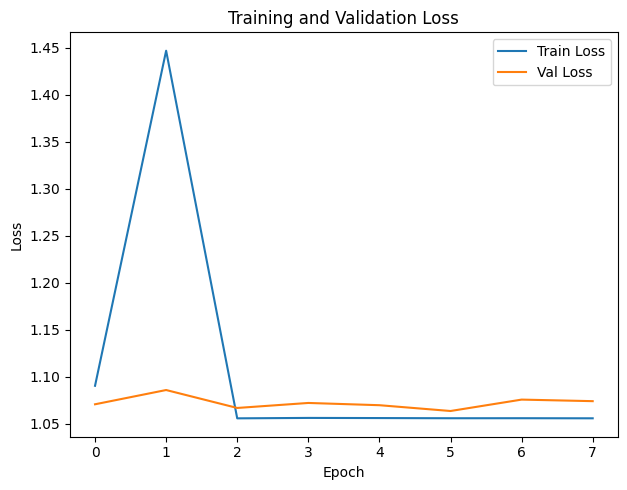

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Load test labels
test_labels = build_label_dict(os.path.join(DATA_DIR, 'test_sent_emo.csv'))

# Load test audio features
audio_loader = dataloader(mode='Sentiment')
audio_loader.load_audio_data()
audio_feats_test = audio_loader.test_audio_emb  # get test audio embeddings

# Create test Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = AudioVideoDataset(audio_feats_test, './frames/test', test_labels, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Labels used for this classification:  {'neutral': 0, 'positive': 1, 'negative': 2}


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AudioVideoFusion()
model.load_state_dict(torch.load('best_fusion_model_sent.pth', map_location=device))
model.to(device)
model.eval()


/tmp/ipykernel_31/3233016254.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_fusion_model.pth', map_location=device))


AudioVideoFusion(
  (audio_branch): AudioBranch(
    (lstm1): LSTM(1422, 448, batch_first=True, dropout=0.35, bidirectional=True)
    (bn1): BatchNorm1d(896, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lstm2): LSTM(896, 448, batch_first=True, dropout=0.35, bidirectional=True)
    (bn2): BatchNorm1d(896, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=896, out_features=384, bias=True)
    (dropout1): Dropout(p=0.4, inplace=False)
    (bn3): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=384, out_features=192, bias=True)
    (dropout2): Dropout(p=0.4, inplace=False)
  )
  (video_branch): MELD_VGG16(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_si

In [27]:
all_preds_sentiment = []
all_labels_sentiment = []

# all_preds_emotion = []
# all_labels_emotion = []

with torch.no_grad():
    for audio, video, sent_label, emo_label in tqdm(test_loader, desc="Testing"):
        audio, video = audio.to(device), video.to(device)
        sent_label, emo_label = sent_label.to(device), emo_label.to(device)

        sent_logits, emo_logits = model(audio, video)

        sent_preds = torch.argmax(sent_logits, dim=1)
        # emo_preds = torch.argmax(emo_logits, dim=1)

        all_preds_sentiment.append(sent_preds.cpu())
        all_labels_sentiment.append(sent_label.cpu())

        # all_preds_emotion.append(emo_preds.cpu())
        # all_labels_emotion.append(emo_label.cpu())

# Combine all batches
all_preds_sentiment = torch.cat(all_preds_sentiment)
all_labels_sentiment = torch.cat(all_labels_sentiment)
# all_preds_emotion = torch.cat(all_preds_emotion)
# all_labels_emotion = torch.cat(all_labels_emotion)

Testing: 100%|██████████| 653/653 [00:13<00:00, 46.99it/s]


In [30]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Sentiment Evaluation
sentiment_acc = accuracy_score(all_labels_sentiment, all_preds_sentiment)
sentiment_f1 = f1_score(all_labels_sentiment, all_preds_sentiment, average='macro')

# Emotion Evaluation
# emotion_acc = accuracy_score(all_labels_emotion, all_preds_emotion)
# emotion_f1 = f1_score(all_labels_emotion, all_preds_emotion, average='macro')

print(f"Test Set Sentiment Accuracy: {sentiment_acc:.4f}")
print(f"Test Set Sentiment Macro F1: {sentiment_f1:.4f}")

# print(f"Test Set Emotion Accuracy: {emotion_acc:.4f}")
# print(f"Test Set Emotion Macro F1: {emotion_f1:.4f}")

print("Sentiment Confusion Matrix:\n", confusion_matrix(all_labels_sentiment, all_preds_sentiment))
# print("Emotion Confusion Matrix:\n", confusion_matrix(all_labels_emotion, all_preds_emotion))
print(classification_report(all_labels_sentiment, all_preds_sentiment, target_names=['neutral', 'positive', 'negative']))

Test Set Sentiment Accuracy: 0.4812
Test Set Sentiment Macro F1: 0.2166
Sentiment Confusion Matrix:
 [[1256    0    0]
 [ 521    0    0]
 [ 833    0    0]]
              precision    recall  f1-score   support

     neutral       0.48      1.00      0.65      1256
    positive       0.00      0.00      0.00       521
    negative       0.00      0.00      0.00       833

    accuracy                           0.48      2610
   macro avg       0.16      0.33      0.22      2610
weighted avg       0.23      0.48      0.31      2610



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
def train_model(model, train_loader, val_loader, device, epochs=30):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # class_counts = [1256, 521, 833]
    
    # Inverse proportional weights
    # weights = torch.tensor([1.0/c for c in class_counts], dtype=torch.float32)
    # weights = weights / weights.sum()  # normalize
    # sent_criterion = nn.CrossEntropyLoss(weight=weights.to(device))
    sent_criterion = nn.CrossEntropyLoss()
    emo_criterion = nn.CrossEntropyLoss()
    model.to(device)

    best_loss = float('inf')
    trigger_times = 0
    patience = 5

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for audio, video, sent_label, emo_label in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
            audio, video, sent_label, emo_label = audio.to(device), video.to(device), sent_label.to(device), emo_label.to(device)

            optimizer.zero_grad()
            sent_out, emo_out = model(audio, video)

            loss = emo_criterion(emo_out, emo_label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        val_loss, val_accuracy = evaluate_model(model, val_loader, device, sent_criterion, emo_criterion)
        print(f"Epoch {epoch+1}: Train Loss={train_loss/len(train_loader):.4f}, Val Loss={val_loss:.4f}")

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_fusion_model_emo.pth")
            print("[INFO] Best model saved!")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("[INFO] Early stopping")
                break
    return train_losses, val_losses, val_accuracies

def evaluate_model(model, loader, device, sent_criterion, emo_criterion):
    model.eval()
    total_loss = 0
    # total_correct_sentiment = 0
    total_correct_emotion = 0
    total_samples = 0

    with torch.no_grad():
        for audio, video, sent_label, emo_label in loader:
            audio, video, sent_label, emo_label = audio.to(device), video.to(device), sent_label.to(device), emo_label.to(device)
            sent_out, emo_out = model(audio, video)

            loss = emo_criterion(emo_out, emo_label)
            total_loss += loss.item()

            # sent_preds = torch.argmax(sent_out, dim=1)
            emo_preds = torch.argmax(emo_out, dim=1)

            # total_correct_sentiment += (sent_preds == sent_label).sum().item()
            total_correct_emotion += (emo_preds == emo_label).sum().item()
            total_samples += sent_label.size(0)

    avg_loss = total_loss / len(loader)
    # sentiment_accuracy = total_correct_sentiment / total_samples
    emotion_accuracy = total_correct_emotion / total_samples

    print(f"Evaluation Results - Loss: {avg_loss:.4f}, Emotion Accuracy: {emotion_accuracy:.4f}")#, Emotion Accuracy: {emotion_accuracy:.4f}")
    return avg_loss, emotion_accuracy


In [39]:
# Step 1: Frame extraction
if not os.path.exists('train_dataset_emo.pt') or not os.path.exists(os.path.join(FRAME_SAVE_DIR, 'train')):
    if not os.path.exists(os.path.join(FRAME_SAVE_DIR, 'train')):
        extract_frames('train', os.path.join(DATA_DIR, 'train/train_sent_emo.csv'), os.path.join(DATA_DIR, 'train/train_splits'), os.path.join(FRAME_SAVE_DIR, 'train'))
        extract_frames('val', os.path.join(DATA_DIR, 'dev_sent_emo.csv'), os.path.join(DATA_DIR, 'dev/dev_splits_complete'), os.path.join(FRAME_SAVE_DIR, 'val'))
        extract_frames('test', os.path.join(DATA_DIR, 'test_sent_emo.csv'), os.path.join(DATA_DIR, 'test/output_repeated_splits_test'), os.path.join(FRAME_SAVE_DIR, 'test'))

    # Step 2: Label preparation
    train_labels = build_label_dict(os.path.join(DATA_DIR, 'train/train_sent_emo.csv'))
    val_labels = build_label_dict(os.path.join(DATA_DIR, 'dev_sent_emo.csv'))

    # Step 3: Load Audio Features from Dataloader
    audio_loader = dataloader(mode='Emotion')
    audio_loader.load_audio_data()
    audio_feats_train = audio_loader.train_audio_emb
    audio_feats_val = audio_loader.val_audio_emb

    # Step 4: Datasets and Loaders
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = AudioVideoDataset(audio_feats_train, './frames/train', train_labels, transform)
    val_dataset = AudioVideoDataset(audio_feats_val, './frames/val', val_labels, transform)
    torch.save(train_dataset, 'train_dataset_emo.pt')
    torch.save(val_dataset, 'val_dataset_emo.pt')
else:
    train_dataset = torch.load('train_dataset_emo.pt',weights_only=False)
    val_dataset = torch.load('val_dataset_emo.pt',weights_only=False)

In [41]:
# print(train_dataset.audio_feats.shape)
# print(val_dataset.audio_feats.shape)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Step 5: Model
model = AudioVideoFusion(audio_input_dim = 1611)

# Step 6: Train
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, device, epochs=NUM_EPOCHS)

print("Training Complete")

Train Epoch 1: 100%|██████████| 2498/2498 [02:18<00:00, 17.98it/s]


Evaluation Results - Loss: 1.6352, Emotion Accuracy: 0.4238
Epoch 1: Train Loss=1.5755, Val Loss=1.6352
[INFO] Best model saved!


Train Epoch 2: 100%|██████████| 2498/2498 [02:19<00:00, 17.95it/s]


Evaluation Results - Loss: 1.6353, Emotion Accuracy: 0.4238
Epoch 2: Train Loss=1.5408, Val Loss=1.6353


Train Epoch 3: 100%|██████████| 2498/2498 [02:18<00:00, 17.98it/s]


Evaluation Results - Loss: 1.6481, Emotion Accuracy: 0.4238
Epoch 3: Train Loss=1.5395, Val Loss=1.6481


Train Epoch 4: 100%|██████████| 2498/2498 [02:18<00:00, 17.98it/s]


Evaluation Results - Loss: 1.6366, Emotion Accuracy: 0.4238
Epoch 4: Train Loss=1.5400, Val Loss=1.6366


Train Epoch 5: 100%|██████████| 2498/2498 [02:18<00:00, 18.01it/s]


Evaluation Results - Loss: 1.6395, Emotion Accuracy: 0.4238
Epoch 5: Train Loss=1.5392, Val Loss=1.6395


Train Epoch 6: 100%|██████████| 2498/2498 [02:18<00:00, 18.01it/s]


Evaluation Results - Loss: 1.6490, Emotion Accuracy: 0.4238
Epoch 6: Train Loss=1.5400, Val Loss=1.6490
[INFO] Early stopping
Training Complete


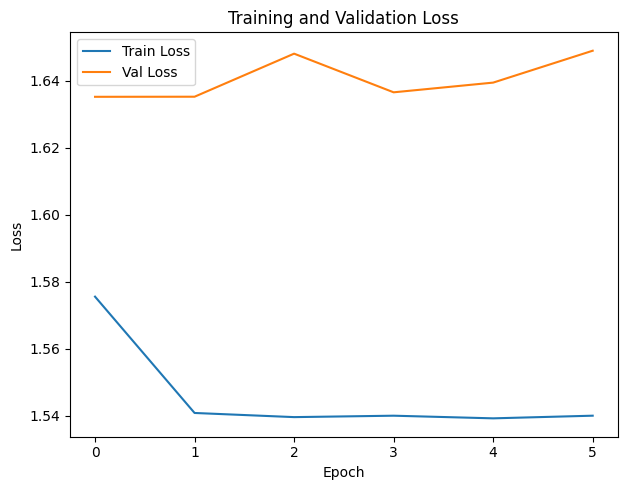

In [45]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
# Load test labels
test_labels = build_label_dict(os.path.join(DATA_DIR, 'test_sent_emo.csv'))

# Load test audio features
audio_loader = dataloader(mode='Emotion')
audio_loader.load_audio_data()
audio_feats_test = audio_loader.test_audio_emb  # get test audio embeddings

# Create test Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = AudioVideoDataset(audio_feats_test, './frames/test', test_labels, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Labels used for this classification:  {'neutral': 0, 'surprise': 1, 'fear': 2, 'sadness': 3, 'joy': 4, 'disgust': 5, 'anger': 6}


In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AudioVideoFusion(audio_input_dim = 1611)
model.load_state_dict(torch.load('best_fusion_model_emo.pth', map_location=device))
model.to(device)
model.eval()


/tmp/ipykernel_31/1105602374.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_fusion_model_emo.pth', map_location=device))


AudioVideoFusion(
  (audio_branch): AudioBranch(
    (lstm1): LSTM(1611, 448, batch_first=True, dropout=0.35, bidirectional=True)
    (bn1): BatchNorm1d(896, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lstm2): LSTM(896, 448, batch_first=True, dropout=0.35, bidirectional=True)
    (bn2): BatchNorm1d(896, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=896, out_features=384, bias=True)
    (dropout1): Dropout(p=0.4, inplace=False)
    (bn3): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=384, out_features=192, bias=True)
    (dropout2): Dropout(p=0.4, inplace=False)
  )
  (video_branch): MELD_VGG16(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_si

In [51]:
# all_preds_sentiment = []
# all_labels_sentiment = []

all_preds_emotion = []
all_labels_emotion = []

with torch.no_grad():
    for audio, video, sent_label, emo_label in tqdm(test_loader, desc="Testing"):
        audio, video = audio.to(device), video.to(device)
        sent_label, emo_label = sent_label.to(device), emo_label.to(device)

        sent_logits, emo_logits = model(audio, video)

        # sent_preds = torch.argmax(sent_logits, dim=1)
        emo_preds = torch.argmax(emo_logits, dim=1)

        # all_preds_sentiment.append(sent_preds.cpu())
        # all_labels_sentiment.append(sent_label.cpu())

        all_preds_emotion.append(emo_preds.cpu())
        all_labels_emotion.append(emo_label.cpu())

# Combine all batches
# all_preds_sentiment = torch.cat(all_preds_sentiment)
# all_labels_sentiment = torch.cat(all_labels_sentiment)
all_preds_emotion = torch.cat(all_preds_emotion)
all_labels_emotion = torch.cat(all_labels_emotion)

Testing: 100%|██████████| 653/653 [00:13<00:00, 46.88it/s]


In [52]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Sentiment Evaluation
# sentiment_acc = accuracy_score(all_labels_sentiment, all_preds_sentiment)
# sentiment_f1 = f1_score(all_labels_sentiment, all_preds_sentiment, average='macro')

# Emotion Evaluation
emotion_acc = accuracy_score(all_labels_emotion, all_preds_emotion)
emotion_f1 = f1_score(all_labels_emotion, all_preds_emotion, average='macro')

# print(f"Test Set Sentiment Accuracy: {sentiment_acc:.4f}")
# print(f"Test Set Sentiment Macro F1: {sentiment_f1:.4f}")

print(f"Test Set Emotion Accuracy: {emotion_acc:.4f}")
print(f"Test Set Emotion Macro F1: {emotion_f1:.4f}")

# print("Sentiment Confusion Matrix:\n", confusion_matrix(all_labels_sentiment, all_preds_sentiment))
print("Emotion Confusion Matrix:\n", confusion_matrix(all_labels_emotion, all_preds_emotion))

print(classification_report(all_labels_emotion, all_preds_emotion, target_names=['neutral', 'anger', 'disgust', 'sadness', 'joy', 'surprise', 'fear']))

Test Set Emotion Accuracy: 0.4812
Test Set Emotion Macro F1: 0.0928
Emotion Confusion Matrix:
 [[1256    0    0    0    0    0    0]
 [ 345    0    0    0    0    0    0]
 [  68    0    0    0    0    0    0]
 [ 208    0    0    0    0    0    0]
 [ 402    0    0    0    0    0    0]
 [ 281    0    0    0    0    0    0]
 [  50    0    0    0    0    0    0]]
              precision    recall  f1-score   support

     neutral       0.48      1.00      0.65      1256
       anger       0.00      0.00      0.00       345
     disgust       0.00      0.00      0.00        68
     sadness       0.00      0.00      0.00       208
         joy       0.00      0.00      0.00       402
    surprise       0.00      0.00      0.00       281
        fear       0.00      0.00      0.00        50

    accuracy                           0.48      2610
   macro avg       0.07      0.14      0.09      2610
weighted avg       0.23      0.48      0.31      2610



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
